# 创新环境分析

In [15]:
import matplotlib.pyplot as plt
plt.rc('font', size=16)                    # controls default text sizes
plt.rc('axes', titlesize=16)               # fontsize of the axes title
plt.rc('axes', labelsize=16)               # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)              # fontsize of the tick labels
plt.rc('ytick', labelsize=14)              # fontsize of the tick labels
plt.rc('legend', fontsize=14)              # legend fontsize
plt.rc('figure', titlesize=18)             # fontsize of the figure title
plt.rc('lines', linewidth=0.8)             # line width
plt.rc('axes', labelpad=5)                 # fontsize of the x and y labels
plt.rc('font', family='Source Serif Pro')  # font family of normal text
plt.rc('mathtext', fontset='cm')           # font family of math equation 

## RPA，RIL，RCL等参数的计算

In [19]:
import pandas as pd
from math import tanh, log

def count_developers(df):
    """ Count the number of developers in df
    """
    df['index'] = range(df.shape[0])
    df = df.set_index('index')
    developers = []
    for i in range(df.shape[0]):
        developers += str(df.loc[i, 'Ultimate Parent']).split('|')
    developers = list(set(developers))
    return len(developers)


def get_rpa(df_ij,df_ia,df_aj,df_aa):
    """ Calculate RPA, RIL and RCL

    Prams:
        df_ij: country i product j
        df_ia: country i all products
        df_aj: all countries product j
        df_aa: all countries all products

    Returns:
        RPA, RIL, RCL
    """
    p_ij = df_ij.shape[0]
    p_ia = df_ia.shape[0]
    p_aj = df_aj.shape[0]
    p_aa = df_aa.shape[0]
    a_ij = count_developers(df_ij)
    a_ia = count_developers(df_ia)
    a_aj = count_developers(df_aj)
    a_aa = count_developers(df_aa)

    try:
        rpa = tanh(log((p_ij/p_ia)/(p_aj/p_aa)))
    except:
        rpa = -1   
    
    try:
        ril = tanh(log((a_ij/a_ia)/(a_aj/a_aa)))
    except:
        ril = -1

    try:
        rcl = tanh(log(((p_ij/a_ij)/(p_ia/a_ia))/((p_aj/a_aj)/(p_aa/a_aa))))
    except:
        rcl = -1  

    return rpa, ril, rcl

## 读取数据

In [20]:
df = pd.read_csv('data/data_processed.csv')
df.columns

Index(['Title', 'Assignee', 'Number of Backward Citations',
       'Number of Forward Citations', 'Est. Expiration Date', 'Status',
       'Project: Labels', 'All IP Classifications', 'Country',
       'Publication Number', 'All CP Classifications', 'Normalized Assignee',
       'Original Assignee', 'Ultimate Parent', 'Publication Date',
       'Application Publication Date', 'Inventors', 'PatentStrength',
       'Priority Date', 'Grant Date', 'File Date', 'Year', 'EYear', 'origin',
       'fixed', 'floating', 'gravity-based', 'jacket', 'monopile', 'tripod',
       'tripile', 'suction bucket', 'tlp', 'spar', 'semi-submersible',
       'Region'],
      dtype='object')

In [3]:
import numpy as np

df = df[np.logical_or(df['fixed']==True,df['floating']==True)]
df['index']=range(df.shape[0])
df = df.set_index('index')

## 定义技术领域

In [4]:
fields = ['gravity-based', 'jacket', 'monopile', 'tripod',
          'tripile', 'suction bucket', 'tlp', 'spar', 'semi-submersible']

## 环境演变历程分析

In [11]:
from itertools import cycle
import numpy as np
pd.options.mode.chained_assignment = None

def draw_rpa(df1, df2, field, y1, y2, width):
    
    # calculate rpa, ril and rcl
    df_ = pd.DataFrame()
    for y in range(y1, y2):
        df_aa = df1[(df1['Year'] <= y)&(df1['Year'] > y-width )]
        df_ia = df2[(df2['Year'] <= y)&(df2['Year'] > y-width )]
        df_aj = df_aa[df_aa[field] == True]
        df_ij = df_ia[df_ia[field] == True]
        rpa, ril, rcl = get_rpa(df_ij, df_ia, df_aj, df_aa)
        df_ = df_.append({'Year': y,
                        'RPA': rpa,
                        'RIL': ril,
                        'RCL': rcl}, ignore_index=True)
   
    # draw lines
    lines = ["--", "v:", "o-", ":", '--', 'D-', 'v-', 'x-', '*-']
    colors = [ 'r', 'g', 'b', 'y', 'purple', 'peru']
    linecycler = cycle(lines)
    colorcycler = cycle(colors)
    
    plt.figure(figsize=(6, 3))
    for _ in ['RPA', 'RIL', 'RCL']:
        plt.plot(df_['Year'], df_[_], next(linecycler),
                 color=next(colorcycler), label=_)
    plt.axhline(0,color='black',linestyle='-',linewidth=0.5)
    plt.legend(ncol=3,frameon=False)
    plt.xlabel('Year')
    plt.ylabel('')
    plt.xticks(np.arange(y1, y2, 1.0))
    plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.2)
    #plt.show()

### 算例

In [12]:
for field in fields:
    for country in ['CN','US']:
        draw_rpa(df, df[df['Country']==country],field,2010,2020,3)
        plt.savefig('evolution/evolution_%s_%s.pdf'%(country,field))
        plt.clf()
    
    draw_rpa(df, df[df['Region']=='Europe'],field,2010,2020,3)
    plt.savefig('evolution/evolution_EU_%s.pdf'%(field))
    plt.clf()

/Users/haiming/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/haiming/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/haiming/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control th

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

<Figure size 432x216 with 0 Axes>

## SWOC分析

In [13]:
fields = ['gravity-based','jacket','monopile','tripod','tripile','suction bucket','tlp','spar','semi-submersible']
labels = {'gravity-based':'grav.',
         'jacket':'jack.',
         'monopile':'mono.',
         'tripod':'tripod',
         'tripile':'tripile',
         'suction bucket':'suct.',
         'tlp':'tlp',
         'spar':'spar',
         'semi-submersible':'semi.'}

In [22]:
fields = ['gravity-based','jacket','monopile','tripod','tripile','suction bucket','tlp','spar','semi-submersible']
labels = {'gravity-based':'grav',
         'jacket':'jack',
         'monopile':'mono',
         'tripod':'tripod',
         'tripile':'tripile',
         'suction bucket':'suct',
         'tlp':'tlp',
         'spar':'spar',
         'semi-submersible':'semi'}

In [16]:
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
from adjustText import adjust_text
pd.options.mode.chained_assignment = None

def swoc(df1, df2):
    
    # calculate rpa, ril and rcl
    df_ = pd.DataFrame()
    for field in fields:
        df_aa = df1
        df_ia = df2
        df_aj = df_aa[df_aa[field] == True]
        df_ij = df_ia[df_ia[field] == True]
        rpa, ril, rcl = get_rpa(df_ij, df_ia, df_aj, df_aa)
        if rpa != -1:
            df_ = df_.append({'Field': field,
                            'RPA': rpa,
                            'RIL': ril,
                            'RCL': rcl}, ignore_index=True)

    print(df_)
    
    plt.rcParams['font.family'] = 'Source Serif Pro'
    plt.rcParams['font.size'] = 14
    plt.rcParams['figure.dpi'] = 96
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 4
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['axes.labelpad'] = 5
    plt.rcParams['figure.figsize'] = [4.3, 4]    
    
    # draw scatter

    points = []
    
    for i in range(df_.shape[0]):
        plt.scatter(df_.loc[i,'RIL'],df_.loc[i,'RCL'])
        points.append(plt.text(df_.loc[i,'RIL'],df_.loc[i,'RCL'],labels[df_.loc[i,'Field']]))
        #points.append(plt.text(df_.loc[i,'RIL'],df_.loc[i,'RCL'],df_.loc[i,'Field']))
    
    # guide lines
    plt.axhline(0,color='r',linestyle='-',linewidth=0.5)
    plt.axvline(0,color='r',linestyle='-',linewidth=0.5)
    
    # chart range
    #xlim = max(abs(df_['RIL'].max()),abs(df_['RIL'].min()))+0.04 
    #ylim = max(abs(df_['RCL'].max()),abs(df_['RCL'].min()))+0.04
    #lim = max(xlim,ylim)
    #plt.xlim(-lim,lim)
    #plt.ylim(-lim,lim)
    
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xticks(np.arange(-1, 1.1, 0.5))
    plt.yticks(np.arange(-0.5, 1.1, 0.5))
    
    # labels
    plt.xlabel('RIL')
    plt.ylabel('RCL')

    # chart size
    plt.subplots_adjust(left=0.21, right=0.95, top=0.95, bottom=0.15)
    
    # avoid overlapping
    adjust_text(points,only_move={'points':'x'})
    #adjust_text(points)
    
    #plt.show()

### 算例

In [23]:
for country in ['CN','US','KR','JP','DE','GB','EP','ES']:    
    swoc(df[df['Year']>=2015],df[(df['Country']==country)&(df['Year']>=2015)])
    plt.savefig('swoc/matrix_%s.pdf'%(country))
    plt.clf()
for region in ['East Asia','North America','Europe']:    
    swoc(df[df['Year']>=2015],df[(df['Region']==region)&(df['Year']>=2015)])
    plt.savefig('swoc/matrix_%s.pdf'%(region))
    plt.clf()

              Field       RCL       RIL       RPA
0     gravity-based -0.367425 -0.043653 -0.404589
1            jacket -0.107009  0.030859 -0.076402
2          monopile  0.161501  0.036451  0.196793
3            tripod  0.334857 -0.316227  0.020836
4           tripile  0.121764 -0.279028 -0.162795
5    suction bucket  0.378693 -0.319745  0.067069
6               tlp -0.066410 -0.084303 -0.149874
7              spar -0.089683 -0.215294 -0.299200
8  semi-submersible -0.580400 -0.061668 -0.619881
              Field       RCL       RIL       RPA
0     gravity-based -0.143885  0.141224 -0.002716
1            jacket -0.064757  0.359045  0.301294
2          monopile -0.041294 -0.414450 -0.448075
3           tripile  0.373006  0.203818  0.536070
4    suction bucket -0.229255  0.498749  0.304286
5               tlp -0.092751  0.660951  0.605307
6              spar  0.245138  0.628498  0.757005
7  semi-submersible -0.120996  0.574851  0.487782
              Field       RCL       RIL       RPA


<Figure size 412.8x384 with 0 Axes>

              Field       RCL       RIL       RPA
0     gravity-based -0.108099  0.519614  0.436005
1          monopile -0.212388  0.464857  0.280127
2            tripod  0.360086  0.940106  0.971366
3              spar  0.527522 -0.256650  0.313288
4  semi-submersible -0.056991  0.549992  0.508954


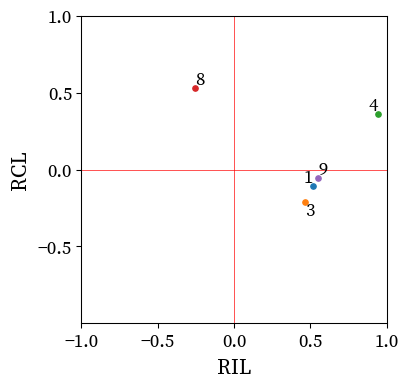

In [21]:
swoc(df[df['Year']>=2015],df[(df['Country']=='GB')&(df['Year']>=2015)])

### 统计

In [225]:
a = df[(df['Region']=='North America')&(df['Year']>=2015)].shape[0]
b = df[(df['Country']=='US')&(df['Year']>=2015)].shape[0]
print(a,b,b/a)

133 117 0.8796992481203008


In [226]:
a = df[(df['Region']=='East Asia')&(df['Year']>=2015)].shape[0]
b = df[(df['Country']=='CN')&(df['Year']>=2015)].shape[0]
print(a,b,b/a)

950 827 0.8705263157894737


In [227]:
a = df[(df['Region']=='Europe')&(df['Year']>=2015)].shape[0]
b = df[(df['Country']=='EP')&(df['Year']>=2015)].shape[0]
print(a,b,b/a)

280 91 0.325
